# 1. Preparation

Import all necessary libraries

In [1]:
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import json

import requests
import io
import time
import random

from sklearn.cluster import KMeans
print("OK")



OK


In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("OK")

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

## 1.1 Get source data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

Data downloaded!


 ## 1.2 Transform data into dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

## 1.3 Get the geographical coordinates of Manhattan.

In [6]:
#manhattan_data.to_csv('Manhattan_data.csv')
#drop data where demographic data is not avaliable right now, And 27 Neighborhoods are left as below.
Manhattan_data=pd.read_csv('Manhattan_data_cleaned.csv')
Manhattan_data

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude
0,0,Manhattan,Marble Hill,40.876551,-73.910660
1,1,Manhattan,Chinatown,40.715618,-73.994279
2,2,Manhattan,Washington Heights,40.851903,-73.936900
3,3,Manhattan,Hamilton Heights,40.823604,-73.949688
4,4,Manhattan,Manhattanville,40.816934,-73.957385
5,5,Manhattan,Central Harlem,40.815976,-73.943211
6,6,Manhattan,East Harlem,40.792249,-73.944182
7,7,Manhattan,Upper East Side,40.775639,-73.960508
8,8,Manhattan,Yorkville,40.775930,-73.947118
9,9,Manhattan,Upper West Side,40.787658,-73.977059


In [7]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


## 1.4 Visualizat Manhattan neighborhoods

In [9]:
manhattan_data=Manhattan_data
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

# 2. Preparing Neighborhoods data in Manhattan

define get_category_type function

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'NGS3O2VHQZCWS2FBFBXHLIL52VMJKB3CPGCEE2CBG3TSMUBB' # your Foursquare ID
CLIENT_SECRET = 'HQSGSJINC3M2P1TUWX3FSCT03HUIGTGBZ4OV111DQL5UHANT' # your Foursquare Secret
VERSION = '20190429' # Foursquare API version
LIMIT = 200 

define function to get Nearby Venues

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#Get manhattan vennue data
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Upper West Side
Lincoln Square
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Sutton Place
Turtle Bay
Stuyvesant Town
Hudson Yards


In [16]:
# Remove Neiborhood without demographic data
manhattan_venues=manhattan_venues[ manhattan_venues['Neighborhood'].isin(  Manhattan_data['Neighborhood'] )]


# 3. Clustering Neighborhoods

one hot encoding

In [52]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.000000,0.010000,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.00,0.03,0.0,0.02,0.0
1,Central Harlem,0.0,0.0,0.068182,0.045455,0.00,0.0,0.0,0.0,0.022727,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2,Chelsea,0.0,0.0,0.000000,0.030000,0.01,0.0,0.0,0.0,0.020000,...,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.0
3,Chinatown,0.0,0.0,0.000000,0.040000,0.00,0.0,0.0,0.0,0.010000,...,0.0,0.04,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
4,East Harlem,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0


First, let's write a function to sort the venues in descending order.

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Wine Shop,Clothing Store,Italian Restaurant,Playground,Food Court,Burger Joint
1,Central Harlem,African Restaurant,Public Art,Chinese Restaurant,Seafood Restaurant,Gym / Fitness Center,Cosmetics Shop,French Restaurant,American Restaurant,Pizza Place,Café
2,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,Bakery,Seafood Restaurant,American Restaurant,Theater,Hotel,French Restaurant
3,Chinatown,Chinese Restaurant,American Restaurant,Cocktail Bar,Vietnamese Restaurant,Dim Sum Restaurant,Bakery,Salon / Barbershop,Bar,Dumpling Restaurant,Hotpot Restaurant
4,East Harlem,Deli / Bodega,Mexican Restaurant,Bakery,Latin American Restaurant,Thai Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant,Donut Shop,Liquor Store


In [23]:
#neighborhoods_venues_sorted.to_csv("neighborhoods_venues_sorted")

Run k-means to cluster the neighborhood into 7 clusters.

In [56]:
# set number of clusters
kclusters = 7

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 5, 3, 0, 2, 0, 3, 0, 4, 2], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Manhattan,Marble Hill,40.876551,-73.910660,6,Discount Store,Coffee Shop,Supplement Shop,Big Box Store,Sandwich Place,Shoe Store,Tennis Stadium,Steakhouse,Gym,Bank
1,1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,American Restaurant,Cocktail Bar,Vietnamese Restaurant,Dim Sum Restaurant,Bakery,Salon / Barbershop,Bar,Dumpling Restaurant,Hotpot Restaurant
2,2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Grocery Store,Deli / Bodega,Mobile Phone Shop,Pizza Place,Mexican Restaurant,Spanish Restaurant,Sandwich Place,Chinese Restaurant
3,3,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Pizza Place,Mexican Restaurant,Café,Coffee Shop,Deli / Bodega,Caribbean Restaurant,School,Chinese Restaurant,Sandwich Place,Cocktail Bar
4,4,Manhattan,Manhattanville,40.816934,-73.957385,3,Coffee Shop,Park,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Pharmacy,Bus Station,Other Nightlife,Beer Garden,Food & Drink Shop


In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
# As we can see the neighborhoods similar to Chinatown are  Lower East Side, Gramercy, East Village, Manhattan Valley


# 4. Explore demographic data of Manhattan neighborhoods 

I collected and cleaned all the demographic data from Wiki for each Manhattan neighborhoods

In [64]:
demographics=pd.read_csv("Manhattan_population_cleaned.csv")
demographics.head()

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density
0,Chinatown,"47,844",63.90%,"30,572",144.0
1,Upper East Side,"219,920",8.60%,"18,847",170.3
2,Lower East Side,"72,957",24.90%,"18,166",136.1
3,Upper West Side,"193,867",7.60%,"14,804",166.8
4,Manhattan Valley,"48,983",24%,"11,755",100.0


In [68]:
#As it already sorted, let us get the top 10 asian_population neighborhoods
demographics=demographics[0:11]
demographics

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density
5,Tribeca,"42,742",22.20%,"9,478",73.5
6,Chelsea,"70,150",11.80%,"8,267",82.4
7,Hudson Yards,"70,150",11.80%,"8,267",82.4
8,Murray Hill,"50,742",16.20%,"8,233",151.5
9,Battery Park City,"39,699",20.20%,"8,016",82.7
10,Morningside Heights,"55,929",13.30%,"7,462",120.2
0,Chinatown,"47,844",63.90%,"30,572",144.0
1,Upper East Side,"219,920",8.60%,"18,847",170.3
2,Lower East Side,"72,957",24.90%,"18,166",136.1
3,Upper West Side,"193,867",7.60%,"14,804",166.8


As the client want to open a Chinese Restaurant, even though some neighborhoods may be similar to Chinatown, but we have to remove them from the candidate list. 
As a result,Gramercy and East Village will be removed from the candidate  list as there are few Asian population

In [72]:
target_list=demographics["Neighborhood"]
target_list

5                 Tribeca
6                 Chelsea
7            Hudson Yards
8             Murray Hill
9       Battery Park City
10    Morningside Heights
0               Chinatown
1         Upper East Side
2         Lower East Side
3         Upper West Side
4        Manhattan Valley
Name: Neighborhood, dtype: object

# 5.Explore the Chinese restauarants  in the target neiborhoods(numbers and propotion)

In [73]:
cat_list=manhattan_venues['Venue Category'].unique()
cat_list

array(['Pizza Place', 'Yoga Studio', 'Diner', 'Coffee Shop', 'Donut Shop',
       'Gym', 'Seafood Restaurant', 'Tennis Stadium', 'Video Game Store',
       'Department Store', 'Discount Store', 'Pharmacy',
       'Supplement Shop', 'Shoe Store', 'Steakhouse', 'Ice Cream Shop',
       'Bank', 'American Restaurant', 'Bakery', 'Big Box Store',
       'Sandwich Place', 'Kids Store', 'Deli / Bodega',
       'Chinese Restaurant', 'English Restaurant', 'Cocktail Bar',
       'General Entertainment', 'Greek Restaurant', 'Hotel', 'Museum',
       'Noodle House', 'Garden Center', 'Spa', 'Bubble Tea Shop',
       'Tea Room', 'Bike Shop', 'Roof Deck', 'New American Restaurant',
       'Indie Movie Theater', 'Malay Restaurant', 'Historic Site',
       'Furniture / Home Store', 'Salon / Barbershop',
       'Hotpot Restaurant', 'Spanish Restaurant', 'Korean Restaurant',
       'Dim Sum Restaurant', 'Italian Restaurant', 'Bar',
       'Asian Restaurant', 'Record Shop', 'Vietnamese Restaurant',
       

In [74]:
catering_list=['Diner','Donut Shop','Coffee Shop','Steakhouse','Ice Cream Shop','Bubble Tea Shop', 'Pet Café',
'Wine Shop', 'Frozen Yogurt Shop','Food Truck', 'Dessert Shop','Café','Food & Drink Shop', 'Fried Chicken Joint', 'Cafeteria','Chocolate Shop']
for place in cat_list:
    if place.find("Bar") > -1 or place.find("Restaurant") > -1 :
        catering_list.append(place)
    elif place.find("Joint") > -1 or place.find("Place") > -1 :
        catering_list.append(place)
catering_list

['Diner',
 'Donut Shop',
 'Coffee Shop',
 'Steakhouse',
 'Ice Cream Shop',
 'Bubble Tea Shop',
 'Pet Café',
 'Wine Shop',
 'Frozen Yogurt Shop',
 'Food Truck',
 'Dessert Shop',
 'Café',
 'Food & Drink Shop',
 'Fried Chicken Joint',
 'Cafeteria',
 'Chocolate Shop',
 'Pizza Place',
 'Seafood Restaurant',
 'American Restaurant',
 'Sandwich Place',
 'Chinese Restaurant',
 'English Restaurant',
 'Cocktail Bar',
 'Greek Restaurant',
 'New American Restaurant',
 'Malay Restaurant',
 'Salon / Barbershop',
 'Hotpot Restaurant',
 'Spanish Restaurant',
 'Korean Restaurant',
 'Dim Sum Restaurant',
 'Italian Restaurant',
 'Bar',
 'Asian Restaurant',
 'Vietnamese Restaurant',
 'Restaurant',
 'Snack Place',
 'Ramen Restaurant',
 'Dumpling Restaurant',
 'Shanghai Restaurant',
 'Taiwanese Restaurant',
 'Austrian Restaurant',
 'Mexican Restaurant',
 'Burger Joint',
 'Tapas Restaurant',
 'Caribbean Restaurant',
 'Indian Restaurant',
 'Latin American Restaurant',
 'Sushi Restaurant',
 'Wine Bar',
 'Thai R

In [101]:
Chinese_grouped=Chinese_Restaurent.groupby('Neighborhood').count().sort_values('Venue',ascending=False)
Chinese_grouped.reset_index(inplace=True)

Chinese_grouped=Chinese_grouped[['Neighborhood','Item']]
Chinese_grouped

,Neighborhood,Item
0,Chinatown,22
1,Murray Hill,3
2,Lower East Side,2
3,Manhattan Valley,2
4,Tribeca,2
5,Battery Park City,1
6,Chelsea,1
7,Upper East Side,1
8,Upper West Side,1


In [75]:
#clean data by sorting the same categories but with different expressions together
#df.to_csv('Manhattan_cateringvenue.csv')
df=pd.read_csv('Manhattan_cateringvenue_cleaned.csv')
df.head()

,Item,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
2,3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
3,4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,5,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant


In [76]:
df.shape

(1779, 8)

Get the 10 candicates's venues

In [82]:
# Remove Neiborhood not in the candidate neighborhoods
target_venues=df[ df['Neighborhood'].isin(  target_list )]

In [83]:
target_venues.tail()

,Item,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1774,1775,Hudson Yards,40.756658,-74.000111,Takumi,40.757218,-74.005588,Food Truck
1775,1776,Hudson Yards,40.756658,-74.000111,Romeo and Juliet Coffee,40.760726,-73.997724,Coffee Shop
1776,1777,Hudson Yards,40.756658,-74.000111,Subway,40.760682,-73.997991,Sandwich Place
1777,1778,Hudson Yards,40.756658,-74.000111,East & West,40.759413,-73.995435,Restaurant
1778,1779,Hudson Yards,40.756658,-74.000111,Concourse Cafe,40.758373,-74.002115,Coffee Shop


In [85]:
df=target_venues
target_venues.shape

(508, 8)

In [90]:
df_neighborhood = df.groupby(['Neighborhood'])['Venue Category'].apply(', '.join).reset_index()

df_neighborhood.head()
count1 = df.groupby(['Neighborhood']).count()
count1.reset_index(inplace=True)
df_neighborhood['count']=count1['Venue']
df_neighborhood.sort_values(by='count', ascending=False,inplace=True)

df_neighborhood

,Neighborhood,Venue Category,count
2,Chinatown,"Chinese Restaurant, English Restaurant, Bar, G...",66
7,Murray Hill,"Japanese Restaurant, Coffee Shop, Hawaiian Res...",63
10,Upper West Side,"Southern / Soul Food Restaurant, American Rest...",61
1,Chelsea,"Bar, Asian Restaurant, Vegetarian / Vegan Rest...",50
8,Tribeca,"Italian Restaurant, Japanese Restaurant, Salad...",50
9,Upper East Side,"Vegetarian / Vegan Restaurant, Italian Restaur...",50
5,Manhattan Valley,"Vietnamese Restaurant, Italian Restaurant, Bar...",38
4,Lower East Side,"Filipino Restaurant, Italian Restaurant, Coffe...",37
3,Hudson Yards,"American Restaurant, Bar, Ice Cream Shop, Amer...",35
0,Battery Park City,"BBQ Joint, Coffee Shop, Sandwich Place, Americ...",34


In [91]:
df_neighborhood.set_index('Neighborhood',inplace=True)
df_neighborhood

,Venue Category,count
Neighborhood,,
Chinatown,"Chinese Restaurant, English Restaurant, Bar, G...",66
Murray Hill,"Japanese Restaurant, Coffee Shop, Hawaiian Res...",63
Upper West Side,"Southern / Soul Food Restaurant, American Rest...",61
Chelsea,"Bar, Asian Restaurant, Vegetarian / Vegan Rest...",50
Tribeca,"Italian Restaurant, Japanese Restaurant, Salad...",50
Upper East Side,"Vegetarian / Vegan Restaurant, Italian Restaur...",50
Manhattan Valley,"Vietnamese Restaurant, Italian Restaurant, Bar...",38
Lower East Side,"Filipino Restaurant, Italian Restaurant, Coffe...",37
Hudson Yards,"American Restaurant, Bar, Ice Cream Shop, Amer...",35


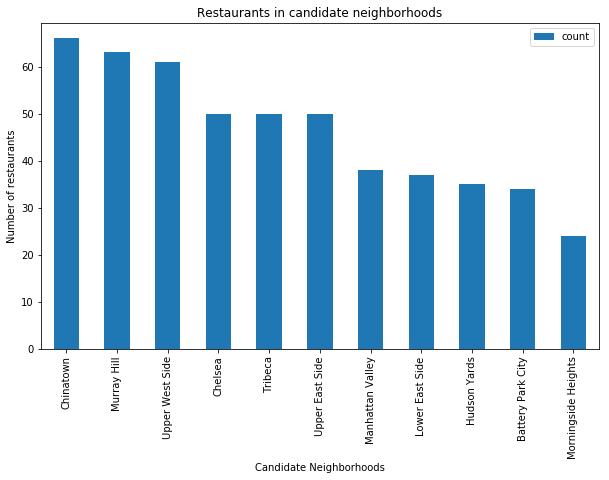

In [93]:
# plot data
df_neighborhood.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Candidate Neighborhoods') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Restaurants in candidate neighborhoods') # add title to the plot

plt.show()

check what catering store are popular in these neighborhoods

In [96]:
cat_count=df[['Neighborhood','Venue Category']].groupby('Venue Category').count()
cat_count=cat_count.rename(columns={'Neighborhood':'Category Count'}).sort_values(by='Category Count', ascending=False)

cat_count=cat_count[0:11]
cat_count

,Category Count
Venue Category,
Bar,66
Coffee Shop,64
Italian Restaurant,36
Chinese Restaurant,35
American Restaurant,27
Japanese Restaurant,26
Ice Cream Shop,15
Pizza Place,15
French Restaurant,13


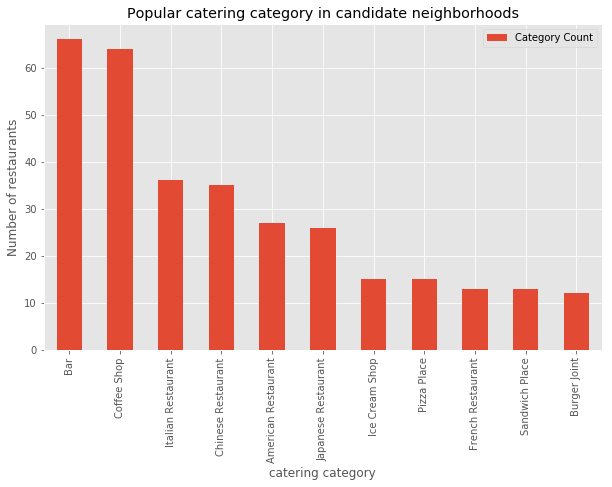

In [103]:
# plot data
cat_count.plot(kind='bar', figsize=(10, 6))

plt.xlabel('catering category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Popular catering category in candidate neighborhoods') # add title to the plot

plt.show()

In [97]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc77991c518>]],
      dtype=object)

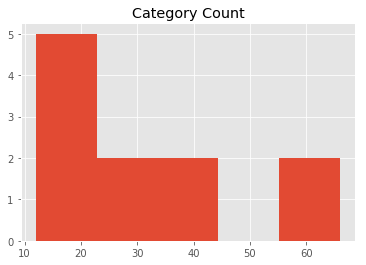

In [98]:
cat_count.hist(bins=5)

Check Chinese Restaurants in candidate neighborhoods

In [99]:
Chinese_Restaurent = df[df['Venue Category'] == 'Chinese Restaurant'].reset_index(drop=True)
Chinese_Restaurent

,Item,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,11,Chinatown,40.715618,-73.994279,Spicy Village,40.717010,-73.993530,Chinese Restaurant
1,17,Chinatown,40.715618,-73.994279,Wah Fung Number 1 Fast Food 華豐快飯店,40.717278,-73.994177,Chinese Restaurant
2,23,Chinatown,40.715618,-73.994279,Xi'an Famous Foods,40.715232,-73.997263,Chinese Restaurant
3,26,Chinatown,40.715618,-73.994279,Little Sheep Mongolian Hot Pot,40.717639,-73.995187,Chinese Restaurant
4,28,Chinatown,40.715618,-73.994279,Great N.Y. Noodletown,40.715039,-73.996941,Chinese Restaurant
5,30,Chinatown,40.715618,-73.994279,Jing Fong Restaurant 金豐大酒樓,40.715881,-73.997209,Chinese Restaurant
6,35,Chinatown,40.715618,-73.994279,Joe's Shanghai 鹿嗚春,40.714692,-73.997701,Chinese Restaurant
7,43,Chinatown,40.715618,-73.994279,99 Favor Taste 99號餐廳,40.717560,-73.992580,Chinese Restaurant
8,46,Chinatown,40.715618,-73.994279,Sun Hing Lung Ho Fun Tofu,40.712968,-73.995149,Chinese Restaurant
9,51,Chinatown,40.715618,-73.994279,Oriental Garden 福臨門海鮮酒家,40.715891,-73.997336,Chinese Restaurant


In [106]:
#get the proportion of Chinese restaurants 
c_per=pd.read_csv("Chinese_restaurant_percentage.csv")
c_per

,Neighborhood,Chinese_Restaurant_#,Total_#,Chinese_Restaurant_percentage
0,Chinatown,22,66,33%
1,Murray Hill,3,63,5%
2,Lower East Side,2,37,5%
3,Manhattan Valley,2,38,5%
4,Tribeca,2,50,4%
5,Battery Park City,1,34,3%
6,Chelsea,1,50,2%
7,Upper East Side,1,50,2%
8,Upper West Side,1,61,2%


get the total number of restautants in candidate neighborhoods

In [108]:
sum=df_neighborhood["count"].sum()
sum

508

get the proportion of restaurants in these neighborhoods in toal

In [115]:
df_neighborhood["restaurant_proportion"]=df_neighborhood["count"]/sum
df_neighborhood["restaurant_proportion"]

Neighborhood
Chinatown              0.129921
Murray Hill            0.124016
Upper West Side        0.120079
Chelsea                0.098425
Tribeca                0.098425
Upper East Side        0.098425
Manhattan Valley       0.074803
Lower East Side        0.072835
Hudson Yards           0.068898
Battery Park City      0.066929
Morningside Heights    0.047244
Name: restaurant_proportion, dtype: float64

The formular to help decision-making

In [116]:
df_restaurant=df_neighborhood.sort_values('Neighborhood',ascending=False)
df_restaurant

,Venue Category,count,proportion,restaurant_proportion
Neighborhood,,,,
Upper West Side,"Southern / Soul Food Restaurant, American Rest...",61,0.120079,0.120079
Upper East Side,"Vegetarian / Vegan Restaurant, Italian Restaur...",50,0.098425,0.098425
Tribeca,"Italian Restaurant, Japanese Restaurant, Salad...",50,0.098425,0.098425
Murray Hill,"Japanese Restaurant, Coffee Shop, Hawaiian Res...",63,0.124016,0.124016
Morningside Heights,"Burger Joint, Salad Place, American Restaurant...",24,0.047244,0.047244
Manhattan Valley,"Vietnamese Restaurant, Italian Restaurant, Bar...",38,0.074803,0.074803
Lower East Side,"Filipino Restaurant, Italian Restaurant, Coffe...",37,0.072835,0.072835
Hudson Yards,"American Restaurant, Bar, Ice Cream Shop, Amer...",35,0.068898,0.068898
Chinatown,"Chinese Restaurant, English Restaurant, Bar, G...",66,0.129921,0.129921


In [113]:
df_c_restaurant=c_per.sort_values('Neighborhood',ascending=False)
df_c_restaurant

,Neighborhood,Chinese_Restaurant_#,Total_#,Chinese_Restaurant_percentage
8,Upper West Side,1,61,2%
7,Upper East Side,1,50,2%
4,Tribeca,2,50,4%
1,Murray Hill,3,63,5%
3,Manhattan Valley,2,38,5%
2,Lower East Side,2,37,5%
0,Chinatown,22,66,33%
6,Chelsea,1,50,2%
5,Battery Park City,1,34,3%


In [118]:
demo_sorted=demographics.sort_values('Neighborhood',ascending=False)
demo_sorted

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density
3,Upper West Side,"193,867",7.60%,"14,804",166.8
1,Upper East Side,"219,920",8.60%,"18,847",170.3
5,Tribeca,"42,742",22.20%,"9,478",73.5
8,Murray Hill,"50,742",16.20%,"8,233",151.5
10,Morningside Heights,"55,929",13.30%,"7,462",120.2
4,Manhattan Valley,"48,983",24%,"11,755",100.0
2,Lower East Side,"72,957",24.90%,"18,166",136.1
7,Hudson Yards,"70,150",11.80%,"8,267",82.4
0,Chinatown,"47,844",63.90%,"30,572",144.0
6,Chelsea,"70,150",11.80%,"8,267",82.4


In [120]:
demo_sorted["Chinese_Restaurant_percentage"]=df_c_restaurant["Chinese_Restaurant_percentage"]
demo_sorted


,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density,Chinese_Restaurant_percentage
3,Upper West Side,"193,867",7.60%,"14,804",166.8,5%
1,Upper East Side,"219,920",8.60%,"18,847",170.3,5%
5,Tribeca,"42,742",22.20%,"9,478",73.5,3%
8,Murray Hill,"50,742",16.20%,"8,233",151.5,2%
10,Morningside Heights,"55,929",13.30%,"7,462",120.2,NaN
4,Manhattan Valley,"48,983",24%,"11,755",100.0,4%
2,Lower East Side,"72,957",24.90%,"18,166",136.1,5%
7,Hudson Yards,"70,150",11.80%,"8,267",82.4,2%
0,Chinatown,"47,844",63.90%,"30,572",144.0,33%
6,Chelsea,"70,150",11.80%,"8,267",82.4,2%


Nan means there are no Chinese restaurants in this neighborhood, it may also be a good candidate place to open one

In [130]:
demo_sorted.replace("NaN", "0", inplace = True)

In [131]:
demo_sorted

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density,Chinese_Restaurant_percentage
3,Upper West Side,"193,867",7.60%,"14,804",166.8,5%
1,Upper East Side,"219,920",8.60%,"18,847",170.3,5%
5,Tribeca,"42,742",22.20%,"9,478",73.5,3%
8,Murray Hill,"50,742",16.20%,"8,233",151.5,2%
10,Morningside Heights,"55,929",13.30%,"7,462",120.2,NaN
4,Manhattan Valley,"48,983",24%,"11,755",100.0,4%
2,Lower East Side,"72,957",24.90%,"18,166",136.1,5%
7,Hudson Yards,"70,150",11.80%,"8,267",82.4,2%
0,Chinatown,"47,844",63.90%,"30,572",144.0,33%
6,Chelsea,"70,150",11.80%,"8,267",82.4,2%


In [139]:
#demo_sorted.to_csv("demo_sorted.csv")
demo_sorted=pd.read_csv("demo_sorted.csv")
demo_sorted

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density,Chinese_Restaurant_percentage
0,Upper West Side,"193,867",7.60%,"14,804",166.8,5.00%
1,Upper East Side,"219,920",8.60%,"18,847",170.3,5.00%
2,Tribeca,"42,742",22.20%,"9,478",73.5,3.00%
3,Murray Hill,"50,742",16.20%,"8,233",151.5,2.00%
4,Morningside Heights,"55,929",13.30%,"7,462",120.2,0.10%
5,Manhattan Valley,"48,983",24%,"11,755",100.0,4.00%
6,Lower East Side,"72,957",24.90%,"18,166",136.1,5.00%
7,Hudson Yards,"70,150",11.80%,"8,267",82.4,2.00%
8,Chinatown,"47,844",63.90%,"30,572",144.0,33.00%
9,Chelsea,"70,150",11.80%,"8,267",82.4,2.00%


# The final_score formula

The final_score formula is as below:
    final_score=Asian_percentage*(1-Chinese_Restaurant_percentage)+population_density/1000

1.We assume that Asian people all likes Chinese food, and only consider competition of the same kind.
2.Asian people are the key target customers so the higher the better.
3.(1-Chinese_Restaurant_percentage) represents the prospect as competition to other Chinese restaurant had been considered and subtracted.
4.Population density had also been considered as an adjustment, because the denser the easier to attract more clients.


In [152]:
#final result:
candidate_lists=pd.read_csv("final_score.csv")
candidate_lists

,Neighborhood,Total_population,Asian_percentage,Asian_population,population_density,Chinese_Restaurant_percentage,final_score
0,Chinatown,"47,844",63.90%,"30,572",144.0,33.00%,57.2130
1,Lower East Side,"72,957",24.90%,"18,166",136.1,5.00%,37.2650
2,Manhattan Valley,"48,983",24%,"11,755",100.0,4.00%,33.0400
3,Tribeca,"42,742",22.20%,"9,478",73.5,3.00%,28.8840
4,Battery Park City,"39,699",20.20%,"8,016",82.7,0.10%,28.4498
5,Murray Hill,"50,742",16.20%,"8,233",151.5,2.00%,31.0260
6,Morningside Heights,"55,929",13.30%,"7,462",120.2,0.10%,25.3067
7,Hudson Yards,"70,150",11.80%,"8,267",82.4,2.00%,19.8040
8,Chelsea,"70,150",11.80%,"8,267",82.4,2.00%,19.8040
9,Upper East Side,"219,920",8.60%,"18,847",170.3,5.00%,25.2000


In [156]:
candidate_plot=candidate_lists[['Neighborhood','final_score']].sort_values('final_score',ascending=False)

candidate_plot.set_index('Neighborhood',inplace=True)

candidate_plot

,final_score
Neighborhood,
Chinatown,57.2130
Lower East Side,37.2650
Manhattan Valley,33.0400
Murray Hill,31.0260
Tribeca,28.8840
Battery Park City,28.4498
Morningside Heights,25.3067
Upper East Side,25.2000
Upper West Side,23.9000


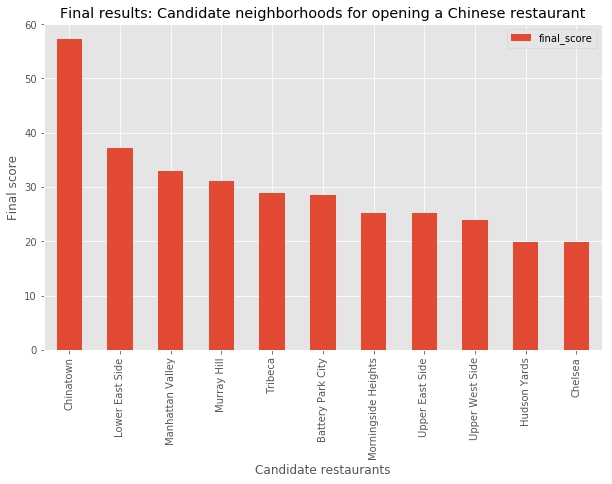

In [157]:
# plot data
candidate_plot.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Candidate restaurants') # add to x-label to the plot
plt.ylabel('Final score') # add y-label to the plot
plt.title('Final results: Candidate neighborhoods for opening a Chinese restaurant') # add title to the plot

plt.show()